In [2]:
# Employee Burnout Risk Prediction - Big Data Analysis
# A comprehensive analysis with data cleaning, EDA, and machine learning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [6]:
# Load your data
try:
    df = pd.read_csv('burnout-train.csv')
    print("✅ Data loaded successfully!")
    print(f"Dataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
except FileNotFoundError:
    print("❌ File 'burnout-train.csv' not found.")
    print("📁 Please make sure the file is in the same directory.")
except Exception as e:
    print(f"❌ Error loading data: {e}")

✅ Data loaded successfully!
Dataset Shape: (22750, 9)
Columns: ['Employee ID', 'Date of Joining', 'Gender', 'Company Type', 'WFH Setup Available', 'Designation', 'Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']


In [5]:

df = pd.read_csv('burnout-train.csv')

# Show first 5 rows
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [8]:

print("\n" + "="*50)
print("📊 DATA QUALITY ASSESSMENT")
print("="*50)

# Check data types
print("\nDATA TYPES:")
print(df.dtypes)

# Check missing values
print("\nMISSING VALUES:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

# Basic statistics
print("\nBASIC STATISTICS:")
df.describe()


📊 DATA QUALITY ASSESSMENT

DATA TYPES:
Employee ID              object
Date of Joining          object
Gender                   object
Company Type             object
WFH Setup Available      object
Designation             float64
Resource Allocation     float64
Mental Fatigue Score    float64
Burn Rate               float64
dtype: object

MISSING VALUES:
                      Missing Count  Percentage
Resource Allocation            1381    6.070330
Mental Fatigue Score           2117    9.305495
Burn Rate                      1124    4.940659

BASIC STATISTICS:


,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


In [9]:
print("\n🎯 CREATING BURNOUT RISK CATEGORIES...")

# Create composite burnout score
df['Composite_Burnout_Score'] = (
    df['Mental Fatigue Score'] * 0.6 + 
    df['Burn Rate'] * 10 * 0.4  # Scale burn rate to match fatigue score range
)

# Create risk categories using quartiles
q1 = df['Composite_Burnout_Score'].quantile(0.25)
q2 = df['Composite_Burnout_Score'].quantile(0.5)
q3 = df['Composite_Burnout_Score'].quantile(0.75)

def categorize_risk(score):
    if score <= q1:
        return 'Low Risk'
    elif score <= q2:
        return 'Medium Risk'
    elif score <= q3:
        return 'High Risk'
    else:
        return 'Critical Risk'

df['Burnout_Risk_Category'] = df['Composite_Burnout_Score'].apply(categorize_risk)

print("✅ Risk Categories Created!")
print("Risk Categories Distribution:")
print(df['Burnout_Risk_Category'].value_counts())


🎯 CREATING BURNOUT RISK CATEGORIES...
✅ Risk Categories Created!
Risk Categories Distribution:
Burnout_Risk_Category
Critical Risk    7977
Medium Risk      4980
Low Risk         4942
High Risk        4851
Name: count, dtype: int64


In [10]:
print("\n🧹 DATA CLEANING...")

# Create a copy for cleaning
cleaned_df = df.copy()

# Handle missing values
print("Handling missing values...")
numerical_cols = cleaned_df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if cleaned_df[col].isnull().sum() > 0:
        median_val = cleaned_df[col].median()
        cleaned_df[col].fillna(median_val, inplace=True)
        print(f"  - Filled {col} missing values with median: {median_val:.2f}")

# Handle categorical missing values
categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if cleaned_df[col].isnull().sum() > 0:
        mode_val = cleaned_df[col].mode()[0]
        cleaned_df[col].fillna(mode_val, inplace=True)
        print(f"  - Filled {col} missing values with mode: {mode_val}")

# Handle date formatting and create tenure
if 'Date of Joining' in cleaned_df.columns:
    cleaned_df['Date of Joining'] = pd.to_datetime(cleaned_df['Date of Joining'])
    current_date = pd.to_datetime('2024-01-01')
    cleaned_df['Tenure_Years'] = (current_date - cleaned_df['Date of Joining']).dt.days / 365.25

# Handle outliers
print("Handling outliers...")
for col in ['Mental Fatigue Score', 'Burn Rate', 'Resource Allocation']:
    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = ((cleaned_df[col] < lower_bound) | 
                    (cleaned_df[col] > upper_bound)).sum()
    
    if outliers_count > 0:
        print(f"  - {col}: {outliers_count} outliers detected and capped")
        cleaned_df[col] = np.clip(cleaned_df[col], lower_bound, upper_bound)

print(f"✅ Data cleaning completed! Shape: {cleaned_df.shape}")



🧹 DATA CLEANING...
Handling missing values...
  - Filled Resource Allocation missing values with median: 4.00
  - Filled Mental Fatigue Score missing values with median: 5.90
  - Filled Burn Rate missing values with median: 0.45
  - Filled Composite_Burnout_Score missing values with median: 5.34
Handling outliers...
  - Mental Fatigue Score: 508 outliers detected and capped
  - Burn Rate: 128 outliers detected and capped
✅ Data cleaning completed! Shape: (22750, 12)



📈 EXPLORATORY DATA ANALYSIS


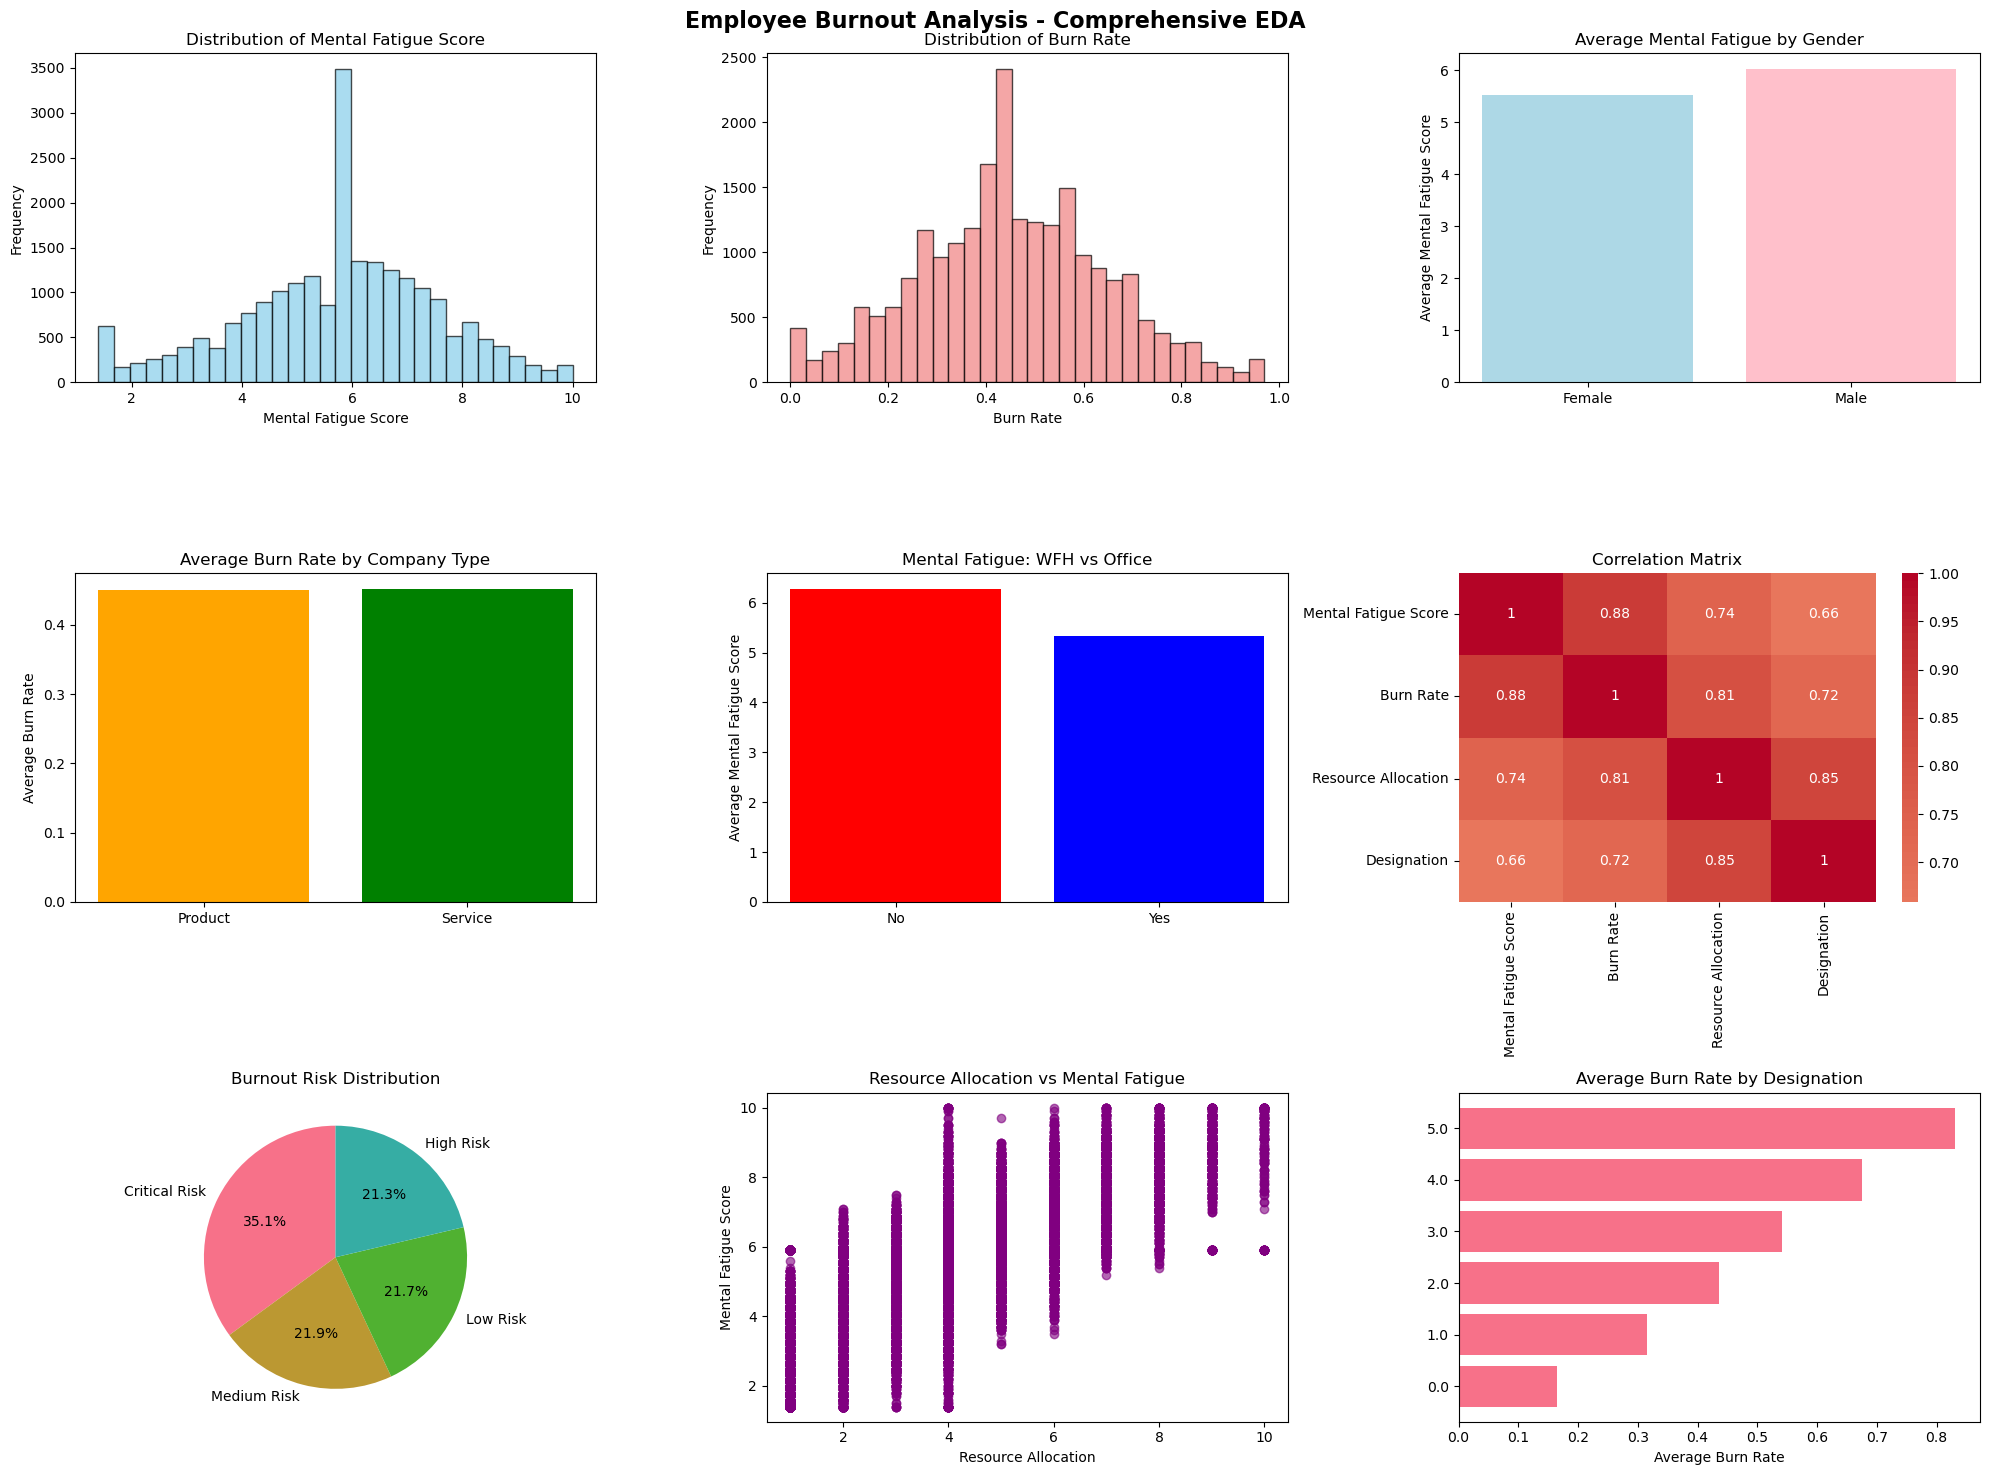

✅ EDA visualizations created!


In [11]:

print("\n📈 EXPLORATORY DATA ANALYSIS")
print("="*40)

# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Employee Burnout Analysis - Comprehensive EDA', fontsize=16, fontweight='bold')

# 1. Distribution of Mental Fatigue Score
axes[0,0].hist(cleaned_df['Mental Fatigue Score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Mental Fatigue Score')
axes[0,0].set_xlabel('Mental Fatigue Score')
axes[0,0].set_ylabel('Frequency')

# 2. Distribution of Burn Rate
axes[0,1].hist(cleaned_df['Burn Rate'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Distribution of Burn Rate')
axes[0,1].set_xlabel('Burn Rate')
axes[0,1].set_ylabel('Frequency')

# 3. Gender vs Mental Fatigue
gender_fatigue = cleaned_df.groupby('Gender')['Mental Fatigue Score'].mean()
axes[0,2].bar(gender_fatigue.index, gender_fatigue.values, color=['lightblue', 'pink'])
axes[0,2].set_title('Average Mental Fatigue by Gender')
axes[0,2].set_ylabel('Average Mental Fatigue Score')

# 4. Company Type vs Burn Rate
company_burn = cleaned_df.groupby('Company Type')['Burn Rate'].mean()
axes[1,0].bar(company_burn.index, company_burn.values, color=['orange', 'green'])
axes[1,0].set_title('Average Burn Rate by Company Type')
axes[1,0].set_ylabel('Average Burn Rate')

# 5. WFH Setup vs Mental Fatigue
wfh_fatigue = cleaned_df.groupby('WFH Setup Available')['Mental Fatigue Score'].mean()
axes[1,1].bar(wfh_fatigue.index, wfh_fatigue.values, color=['red', 'blue'])
axes[1,1].set_title('Mental Fatigue: WFH vs Office')
axes[1,1].set_ylabel('Average Mental Fatigue Score')

# 6. Correlation Heatmap
corr_cols = ['Mental Fatigue Score', 'Burn Rate', 'Resource Allocation', 'Designation']
corr_matrix = cleaned_df[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Correlation Matrix')

# 7. Burnout Risk Categories
risk_counts = cleaned_df['Burnout_Risk_Category'].value_counts()
axes[2,0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90)
axes[2,0].set_title('Burnout Risk Distribution')

# 8. Resource Allocation vs Mental Fatigue
axes[2,1].scatter(cleaned_df['Resource Allocation'], cleaned_df['Mental Fatigue Score'], 
                 alpha=0.6, color='purple')
axes[2,1].set_title('Resource Allocation vs Mental Fatigue')
axes[2,1].set_xlabel('Resource Allocation')
axes[2,1].set_ylabel('Mental Fatigue Score')

# 9. Designation vs Burn Rate
desig_burn = cleaned_df.groupby('Designation')['Burn Rate'].mean().sort_values(ascending=True)
axes[2,2].barh(range(len(desig_burn)), desig_burn.values)
axes[2,2].set_yticks(range(len(desig_burn)))
axes[2,2].set_yticklabels(desig_burn.index)
axes[2,2].set_title('Average Burn Rate by Designation')
axes[2,2].set_xlabel('Average Burn Rate')

plt.tight_layout()
plt.show()

print("✅ EDA visualizations created!")


In [12]:
print("\n🔧 PREPARING DATA FOR MACHINE LEARNING...")

# Create feature matrix
features_df = cleaned_df.copy()

# Encode categorical variables
categorical_features = ['Gender', 'Company Type', 'WFH Setup Available']

for feature in categorical_features:
    if feature in features_df.columns:
        # Create dummy variables
        dummies = pd.get_dummies(features_df[feature], prefix=feature, drop_first=True)
        features_df = pd.concat([features_df, dummies], axis=1)

# Select features for modeling
feature_columns = [
    'Mental Fatigue Score', 'Burn Rate', 'Resource Allocation', 'Designation'
]

# Add encoded categorical features if they exist
if 'Gender_Male' in features_df.columns:
    feature_columns.append('Gender_Male')
if 'Company Type_Service' in features_df.columns:
    feature_columns.append('Company Type_Service')
if 'WFH Setup Available_Yes' in features_df.columns:
    feature_columns.append('WFH Setup Available_Yes')
if 'Tenure_Years' in features_df.columns:
    feature_columns.append('Tenure_Years')

# Handle missing columns
available_features = [col for col in feature_columns if col in features_df.columns]

X = features_df[available_features]

# Create binary target variable (High/Critical risk = 1, Low/Medium = 0)
y = features_df['Burnout_Risk_Category'].apply(
    lambda x: 1 if x in ['High Risk', 'Critical Risk'] else 0
)

print(f"✅ Features prepared: {available_features}")
print(f"Target distribution: {y.value_counts()}")


🔧 PREPARING DATA FOR MACHINE LEARNING...
✅ Features prepared: ['Mental Fatigue Score', 'Burn Rate', 'Resource Allocation', 'Designation', 'Gender_Male', 'Company Type_Service', 'WFH Setup Available_Yes', 'Tenure_Years']
Target distribution: Burnout_Risk_Category
1    12828
0     9922
Name: count, dtype: int64


In [13]:
print("\n🤖 TRAINING MACHINE LEARNING MODELS...")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

# Train and evaluate each model
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc_score': auc_score,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}")

# Select best model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
best_model = model_results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Best AUC Score: {best_model['auc_score']:.4f}")


🤖 TRAINING MACHINE LEARNING MODELS...

Training Random Forest...
Random Forest - Accuracy: 0.9745, AUC: 0.9983

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9811, AUC: 0.9988

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9013, AUC: 0.9691

🏆 Best Model: Gradient Boosting
Best AUC Score: 0.9988



📊 MODEL EVALUATION
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1984
           1       0.98      0.99      0.98      2566

    accuracy                           0.98      4550
   macro avg       0.98      0.98      0.98      4550
weighted avg       0.98      0.98      0.98      4550



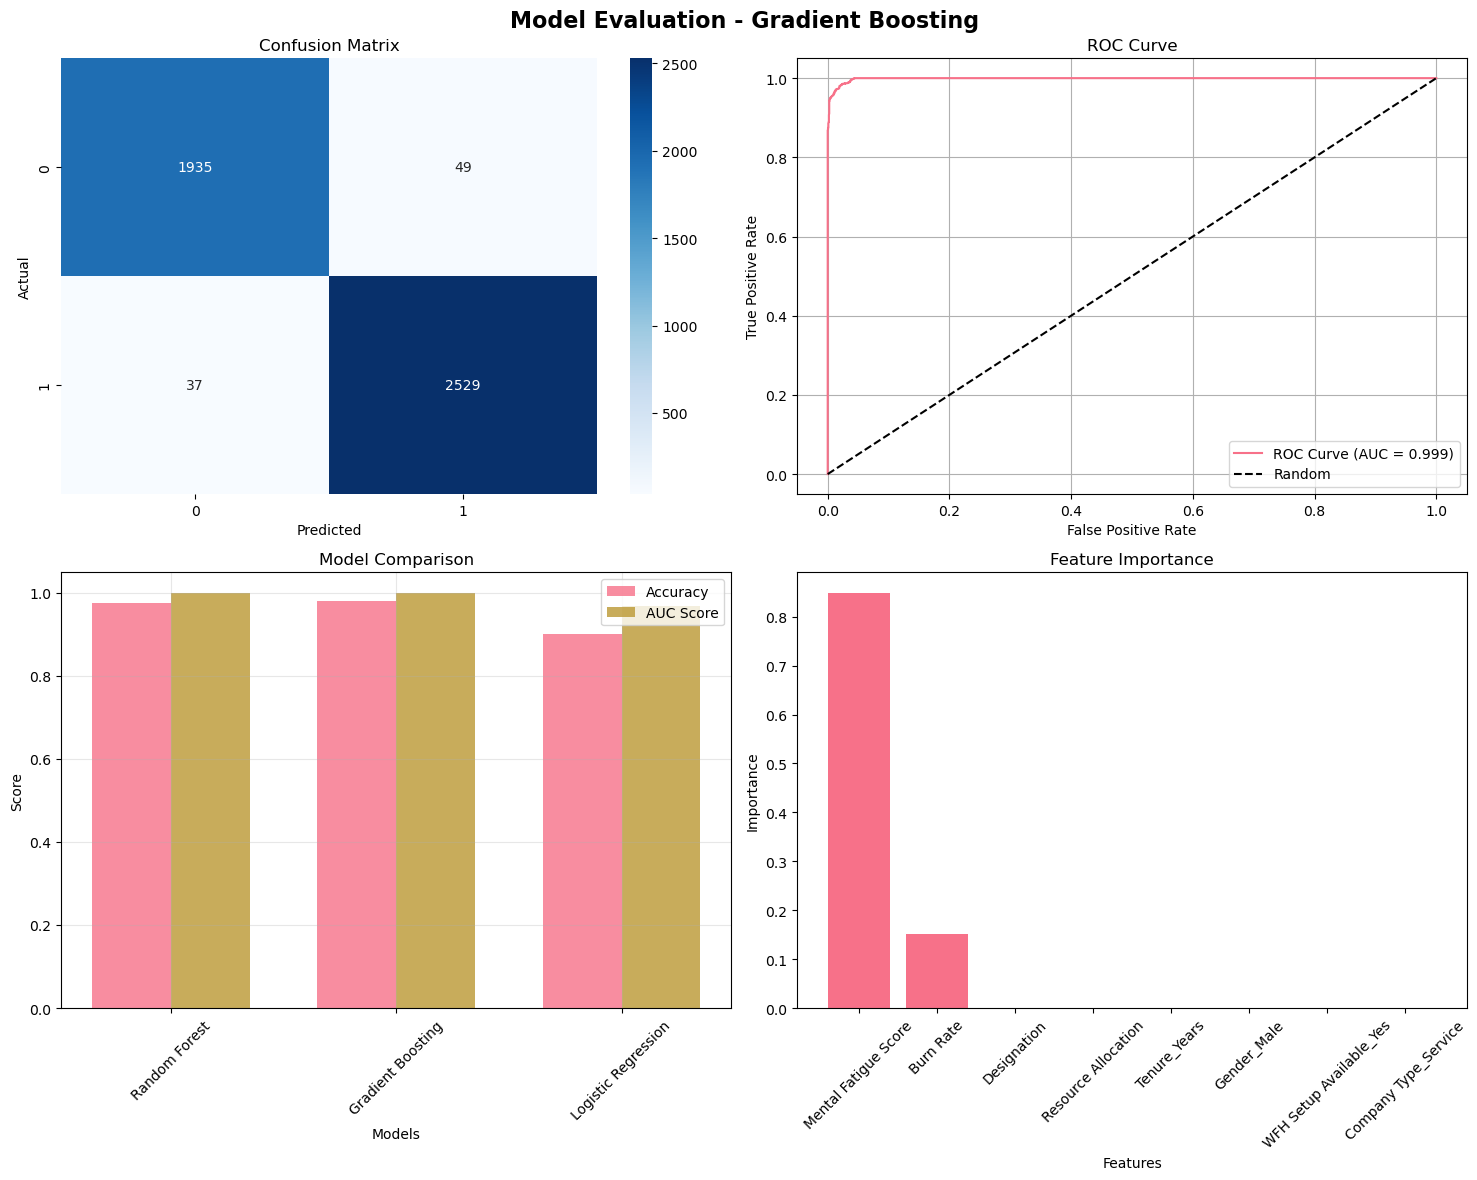

✅ Model evaluation completed!


In [14]:

print("\n📊 MODEL EVALUATION")
print("="*30)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, best_model['y_pred']))

# Create evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Model Evaluation - {best_model_name}', fontsize=16, fontweight='bold')

# 1. Confusion Matrix
cm = confusion_matrix(y_test, best_model['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_model['y_pred_proba'])
axes[0,1].plot(fpr, tpr, label=f'ROC Curve (AUC = {best_model["auc_score"]:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()
axes[0,1].grid(True)

# 3. Model Comparison
model_names = list(model_results.keys())
accuracies = [model_results[name]['accuracy'] for name in model_names]
auc_scores = [model_results[name]['auc_score'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[1,0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
axes[1,0].bar(x + width/2, auc_scores, width, label='AUC Score', alpha=0.8)
axes[1,0].set_xlabel('Models')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Model Comparison')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(model_names, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Feature Importance (for tree-based models)
if hasattr(model_results[best_model_name]['model'], 'feature_importances_'):
    feature_importance = model_results[best_model_name]['model'].feature_importances_
    feature_names = X.columns
    
    # Sort features by importance
    indices = np.argsort(feature_importance)[::-1]
    
    axes[1,1].bar(range(len(feature_importance)), feature_importance[indices])
    axes[1,1].set_xlabel('Features')
    axes[1,1].set_ylabel('Importance')
    axes[1,1].set_title('Feature Importance')
    axes[1,1].set_xticks(range(len(feature_importance)))
    axes[1,1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
else:
    axes[1,1].text(0.5, 0.5, 'Feature importance\nnot available for\nthis model type', 
                  ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

print("✅ Model evaluation completed!")

In [15]:

print("\n💾 EXPORTING DATA FOR POWER BI...")

# Export cleaned data with all new features
cleaned_df.to_csv('cleaned_burnout_data.csv', index=False)

print("✅ Data exported to 'cleaned_burnout_data.csv'")
print("\n🎯 KEY INSIGHTS:")

# Generate quick insights
high_risk_count = len(cleaned_df[cleaned_df['Burnout_Risk_Category'].isin(['High Risk', 'Critical Risk'])])
high_risk_percent = (high_risk_count / len(cleaned_df)) * 100

print(f"1. {high_risk_count} employees ({high_risk_percent:.1f}%) are at high/critical burnout risk")

gender_fatigue = cleaned_df.groupby('Gender')['Mental Fatigue Score'].mean()
if len(gender_fatigue) > 1:
    print(f"2. Average mental fatigue: Male={gender_fatigue.get('Male', 0):.2f}, Female={gender_fatigue.get('Female', 0):.2f}")

wfh_analysis = cleaned_df.groupby('WFH Setup Available')['Mental Fatigue Score'].mean()
if len(wfh_analysis) > 1:
    print(f"3. WFH impact: With WFH={wfh_analysis.get('Yes', 0):.2f}, Without WFH={wfh_analysis.get('No', 0):.2f}")

print(f"\n🏆 Best ML Model: {best_model_name} (AUC: {best_model['auc_score']:.3f})")
print("\n✅ ANALYSIS COMPLETED! Ready for Power BI dashboard creation.")


💾 EXPORTING DATA FOR POWER BI...
✅ Data exported to 'cleaned_burnout_data.csv'

🎯 KEY INSIGHTS:
1. 12828 employees (56.4%) are at high/critical burnout risk
2. Average mental fatigue: Male=6.03, Female=5.52
3. WFH impact: With WFH=5.32, Without WFH=6.28

🏆 Best ML Model: Gradient Boosting (AUC: 0.999)

✅ ANALYSIS COMPLETED! Ready for Power BI dashboard creation.
